<h3>Import Libraries</h3>

In [9]:
import os
import shutil
import random
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

<h3>Data decscription and EDA</h3>

In [2]:
Train_dir = "Museum_Training/Training/"
# Test_dir = "Museum_Test/Museum_Validation/"

classification_targets = ['museum-indoor', 'museum-outdoor']

def check_directory(directory):
    if os.path.exists(directory):
        print(f"Directory '{directory}' exists.")
    else:
        print(f"Directory '{directory}' does NOT exist.")

check_directory(Train_dir)

Directory 'Museum_Training/Training/' exists.


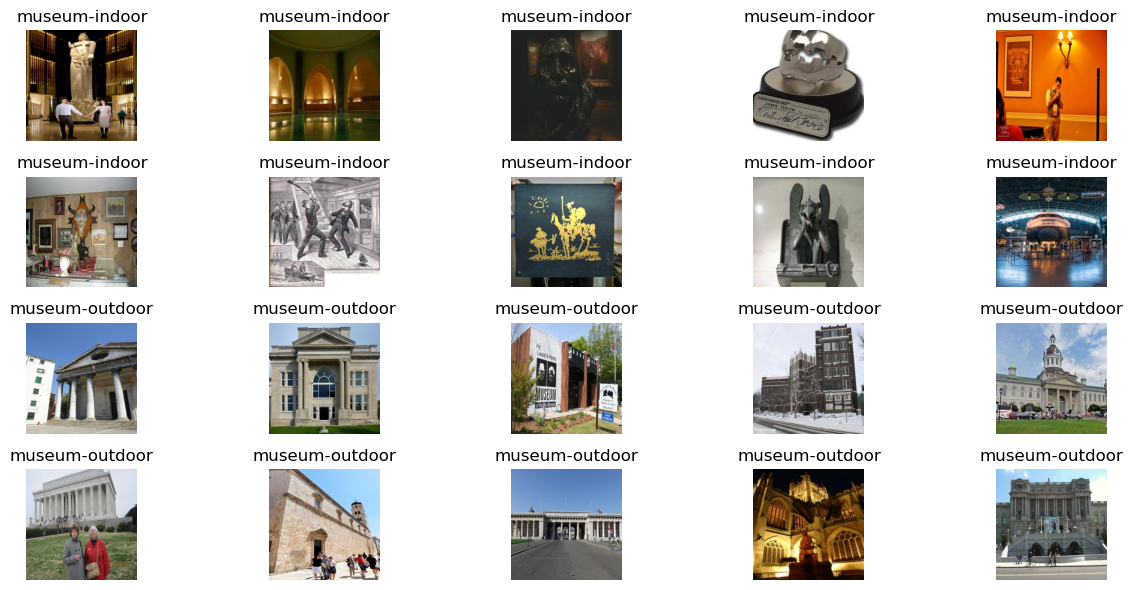

In [ ]:
def show_random_images_from_train(Train_dir, classification_targets, num_images=10, images_per_row=5):
    
    plt.figure(figsize=(13, 6))

    for class_idx, clf in enumerate(classification_targets):
        class_path = os.path.join(Train_dir, clf)

        if not os.path.exists(class_path):
            print(f" Class folder '{clf}' does NOT exist. Skipping.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        if len(image_files) == 0:
            print(f" No images found in class '{clf}'. Skipping.")
            continue

        selected_images = random.sample(image_files, min(num_images, len(image_files)))

        rows = (num_images // images_per_row) + (num_images % images_per_row > 0)

        for i, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f" Could not read image: {img_path}. Skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            ax = plt.subplot(len(classification_targets) * rows, images_per_row, class_idx * rows * images_per_row + i + 1)
            plt.imshow(img)
            plt.title(f"{clf}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images_from_train(Train_dir, classification_targets, num_images=10)

<h3>Pre-process data RGB</h3>

In [ ]:
def is_image_file(filename):
    
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(256,256)):
    
    X = []
    y = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  
                        img = img.resize(image_size)  
                        img_array = np.array(img).flatten()  
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = preprocess_images(Train_dir, classification_targets)


print("Image data shape:", X.shape)
print("Labels shape:", y.shape)

Image data shape: (10000, 196608)
Labels shape: (10000,)


<h3>Apply minmax scaler</h3>

In [6]:
from sklearn.preprocessing import MinMaxScaler


minmaxscaler = MinMaxScaler()
x_minmaxscaled = minmaxscaler.fit_transform(X)
print("Image data shape:", x_minmaxscaled.shape)
 
# X_save_path = ("/content/preprocessed_X_minmaxscaled.npy")
# np.save(X_save_path, x_minmaxscaled)

Image data shape: (10000, 196608)


In [12]:
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(x_minmaxscaled, y, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train_minmax.shape)
print("Testing data shape:", X_test_minmax.shape)

Training data shape: (8000, 196608)
Testing data shape: (2000, 196608)


<h3>Decision tree over the MinMax scaled RGB data</h3>

In [13]:
# Define and train model
dt_model_minmax_entropy = DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_split=2,random_state=42)
dt_model_minmax_entropy.fit(X_train_minmax, y_train_minmax)

y_train_pred = dt_model_minmax_entropy.predict(X_train_minmax)
y_test_pred = dt_model_minmax_entropy.predict(X_test_minmax)

accuracy_train = accuracy_score(y_train_minmax, y_train_pred)
accuracy_test = accuracy_score(y_test_minmax, y_test_pred)

cm_train = confusion_matrix(y_train_minmax, y_train_pred)
cm_test = confusion_matrix(y_test_minmax, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train_minmax, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test_minmax, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)


--- Training Metrics ---
Accuracy: 0.898
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.87      0.94      0.90      4000
museum-outdoor       0.93      0.86      0.89      4000

      accuracy                           0.90      8000
     macro avg       0.90      0.90      0.90      8000
  weighted avg       0.90      0.90      0.90      8000

Confusion Matrix:
 [[3744  256]
 [ 560 3440]]

--- Testing Metrics ---
Accuracy: 0.8405
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.82      0.88      0.85      1000
museum-outdoor       0.87      0.81      0.83      1000

      accuracy                           0.84      2000
     macro avg       0.84      0.84      0.84      2000
  weighted avg       0.84      0.84      0.84      2000

Confusion Matrix:
 [[875 125]
 [194 806]]


In [ ]:
dt_model_gini = DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_split=2,random_state=42)
dt_model_gini.fit(X_train_minmax, y_train_minmax)

y_train_pred = dt_model_gini.predict(X_train_minmax)
y_test_pred = dt_model_gini.predict(X_test_minmax)

accuracy_train = accuracy_score(y_train_minmax, y_train_pred)
accuracy_test = accuracy_score(y_test_minmax, y_test_pred)

cm_train = confusion_matrix(y_train_minmax, y_train_pred)
cm_test = confusion_matrix(y_test_minmax, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train_minmax, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test_minmax, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.885375
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.86      0.92      0.89      4000
museum-outdoor       0.91      0.85      0.88      4000

      accuracy                           0.89      8000
     macro avg       0.89      0.89      0.89      8000
  weighted avg       0.89      0.89      0.89      8000

Confusion Matrix:
 [[3666  334]
 [ 583 3417]]

--- Testing Metrics ---
Accuracy: 0.8575
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.83      0.90      0.86      1000
museum-outdoor       0.89      0.82      0.85      1000

      accuracy                           0.86      2000
     macro avg       0.86      0.86      0.86      2000
  weighted avg       0.86      0.86      0.86      2000

Confusion Matrix:
 [[898 102]
 [183 817]]


<h3>Random Forest algorithm trained over the MinMax Scaled RGB data</h3>

In [ ]:
rf_model = RandomForestClassifier(max_depth=6,n_estimators=100, criterion='entropy', random_state=42) 
rf_model.fit(X_train_minmax, y_train_minmax)

y_train_pred = rf_model.predict(X_train_minmax)
y_test_pred = rf_model.predict(X_test_minmax)

accuracy_train = accuracy_score(y_train_minmax, y_train_pred)
accuracy_test = accuracy_score(y_test_minmax, y_test_pred)

cm_train = confusion_matrix(y_train_minmax, y_train_pred)
cm_test = confusion_matrix(y_test_minmax, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train_minmax, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test_minmax, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)


--- Training Metrics ---
Accuracy: 0.91925
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.90      0.95      0.92      4000
museum-outdoor       0.95      0.89      0.92      4000

      accuracy                           0.92      8000
     macro avg       0.92      0.92      0.92      8000
  weighted avg       0.92      0.92      0.92      8000

Confusion Matrix:
 [[3795  205]
 [ 441 3559]]

--- Testing Metrics ---
Accuracy: 0.901
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.88      0.93      0.90      1000
museum-outdoor       0.93      0.87      0.90      1000

      accuracy                           0.90      2000
     macro avg       0.90      0.90      0.90      2000
  weighted avg       0.90      0.90      0.90      2000

Confusion Matrix:
 [[931  69]
 [129 871]]


In [14]:
rf_model_gini = RandomForestClassifier(max_depth=5,n_estimators=50, criterion='gini', random_state=42)  
rf_model_gini.fit(X_train_minmax, y_train_minmax)

y_train_pred = rf_model_gini.predict(X_train_minmax)
y_test_pred = rf_model_gini.predict(X_test_minmax)

accuracy_train = accuracy_score(y_train_minmax, y_train_pred)
accuracy_test = accuracy_score(y_test_minmax, y_test_pred)

cm_train = confusion_matrix(y_train_minmax, y_train_pred)
cm_test = confusion_matrix(y_test_minmax, y_test_pred)

print('--- Training Metrics ---')
print("Accuracy:", accuracy_train)
print("Classification Report:\n", classification_report(y_train_minmax, y_train_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_train)
print('\n--- Testing Metrics ---')
print("Accuracy:", accuracy_test)
print("Classification Report:\n", classification_report(y_test_minmax, y_test_pred, target_names=classification_targets))
print('Confusion Matrix:\n', cm_test)

--- Training Metrics ---
Accuracy: 0.8995
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.88      0.93      0.90      4000
museum-outdoor       0.92      0.87      0.90      4000

      accuracy                           0.90      8000
     macro avg       0.90      0.90      0.90      8000
  weighted avg       0.90      0.90      0.90      8000

Confusion Matrix:
 [[3702  298]
 [ 506 3494]]

--- Testing Metrics ---
Accuracy: 0.8885
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.87      0.91      0.89      1000
museum-outdoor       0.91      0.87      0.89      1000

      accuracy                           0.89      2000
     macro avg       0.89      0.89      0.89      2000
  weighted avg       0.89      0.89      0.89      2000

Confusion Matrix:
 [[910  90]
 [133 867]]


<h3>Pre-process data for Boosting algorithm</h3>

In [ ]:
def preprocess_images128(target_dir, classes, image_size=(128,128)):
    
    Xmax128 = []
    ymax128 = []

    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  
                        img = img.resize(image_size)  
                        img_array = np.array(img).flatten()  
                        Xmax128.append(img_array)
                        ymax128.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")

    Xmax128 = np.array(Xmax128)
    ymax128 = np.array(ymax128)
    return Xmax128, ymax128

Xmax128, ymax128 = preprocess_images128(Train_dir, classification_targets)


print("Image data shape:", Xmax128.shape)
print("Labels shape:", ymax128.shape)

Image data shape: (10000, 49152)
Labels shape: (10000,)


In [7]:
from sklearn.preprocessing import MinMaxScaler


minmaxscaler = MinMaxScaler()
x_minmaxscaled128 = minmaxscaler.fit_transform(Xmax128)
print("Image data shape:", x_minmaxscaled128.shape)

Image data shape: (10000, 49152)


In [8]:
X_train128max, X_test128max, y_train128max, y_test128max = train_test_split(x_minmaxscaled128, ymax128, test_size=0.2, random_state=42, stratify=y)
print("Training data shape:", X_train128max.shape)
print("Testing data shape:", X_test128max.shape)

Training data shape: (8000, 49152)
Testing data shape: (2000, 49152)


<h3>XGBoost algorithm with MinMax scaled RGB data</h3>

In [10]:
xgb_model = XGBClassifier(max_depth=5, n_estimators=50, learning_rate=0.1, objective="multi:softmax", random_state=42,num_class=2)
xgb_model.fit(X_train128max, y_train128max)


y_train_pred_xgb = xgb_model.predict(X_train128max)
y_test_pred_xgb = xgb_model.predict(X_test128max)


accuracy_train_xgb = accuracy_score(y_train128max, y_train_pred_xgb)
accuracy_test_xgb = accuracy_score(y_test128max, y_test_pred_xgb)


cm_train_xgb = confusion_matrix(y_train128max, y_train_pred_xgb)
cm_test_xgb = confusion_matrix(y_test128max, y_test_pred_xgb)


print("\nXGBoost Training Metrics")
print("Accuracy:", accuracy_train_xgb)
print("Classification Report:\n", classification_report(y_train128max, y_train_pred_xgb, target_names=classification_targets))
print("Confusion Matrix:\n", cm_train_xgb)

print("\nXGBoost Testing Metrics")
print("Accuracy:", accuracy_test_xgb)
print("Classification Report:\n", classification_report(y_test128max, y_test_pred_xgb, target_names=classification_targets))
print("Confusion Matrix:\n", cm_test_xgb)


XGBoost Training Metrics
Accuracy: 0.96975
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.95      0.99      0.97      4000
museum-outdoor       0.99      0.95      0.97      4000

      accuracy                           0.97      8000
     macro avg       0.97      0.97      0.97      8000
  weighted avg       0.97      0.97      0.97      8000

Confusion Matrix:
 [[3958   42]
 [ 200 3800]]

XGBoost Testing Metrics
Accuracy: 0.905
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.89      0.93      0.91      1000
museum-outdoor       0.92      0.88      0.90      1000

      accuracy                           0.91      2000
     macro avg       0.91      0.91      0.90      2000
  weighted avg       0.91      0.91      0.90      2000

Confusion Matrix:
 [[927  73]
 [117 883]]
